#### lets begin with the model identificaiton of motor

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import control
import control.matlab as cm
import pysindy as ps

plt.rcParams.update({
        "font.weight": "bold",  # bold fonts
        "font.size":10,
        "lines.linewidth": 2,   # thick lines
        "grid.color": "0.5",    # gray gridlines
        "grid.linewidth": 0.5,  # thin gridlines
        "savefig.dpi": 300,     # higher resolution output.
        "axes.labelsize" : 15,
        'legend.labelspacing':0.95
    })

In [2]:
data = pd.read_csv('Real_Data/data_150.txt')
data.time = (data.time/1000000)
data.time = data.time -2
data = data.set_index('time')
data.angle = data.angle
data.velocity = data.velocity
data = data.query('time<5')

In [3]:
## note that i have ignored the dynamcis of inductor
Ts = data.index[1] - data.index[0]
t_eval = data.index.values

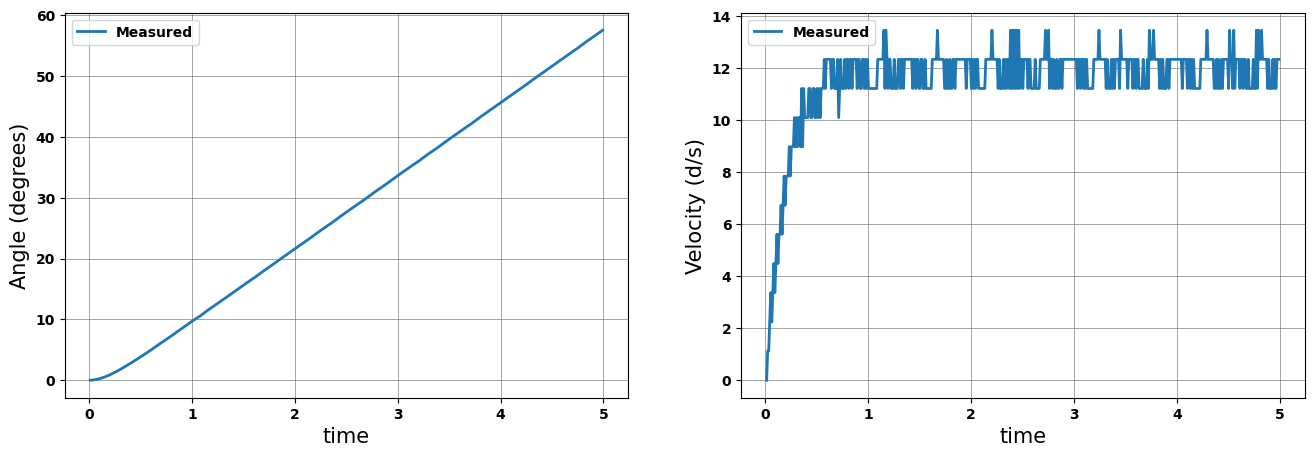

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
data.angle.plot(ax=ax1,label="Measured")
data.velocity.plot(ax=ax2, label = "Measured")
    
ax1.grid()
ax1.set_xlabel('time')
ax1.set_ylabel('Angle (degrees)')
ax2.grid()
ax2.set_xlabel('time')
ax2.set_ylabel('Velocity (d/s)')
#ax1.set_xlim(0,0.65)
#ax2.set_xlim(0,0.65)
ax1.legend()
ax2.legend()
#plt.savefig('Images/rlocus_load.pdf',dpi = 300, bbox_inches='tight')
plt.show()

In [5]:
#lets identify the model
X = data.values
t = data.index.values

differentiation_method = ps.FiniteDifference(order=2)
feature_library = ps.PolynomialLibrary(degree=1)
optimizer = ps.STLSQ(threshold=0.001)

In [6]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"],
)

model.fit(X, t=t)
model.print()

(x)' = 1.162 1 + 0.003 x + 0.892 y
(y)' = 63.563 1 + -0.006 x + -5.267 y


In [7]:
sim = model.simulate([0,0], t=t)

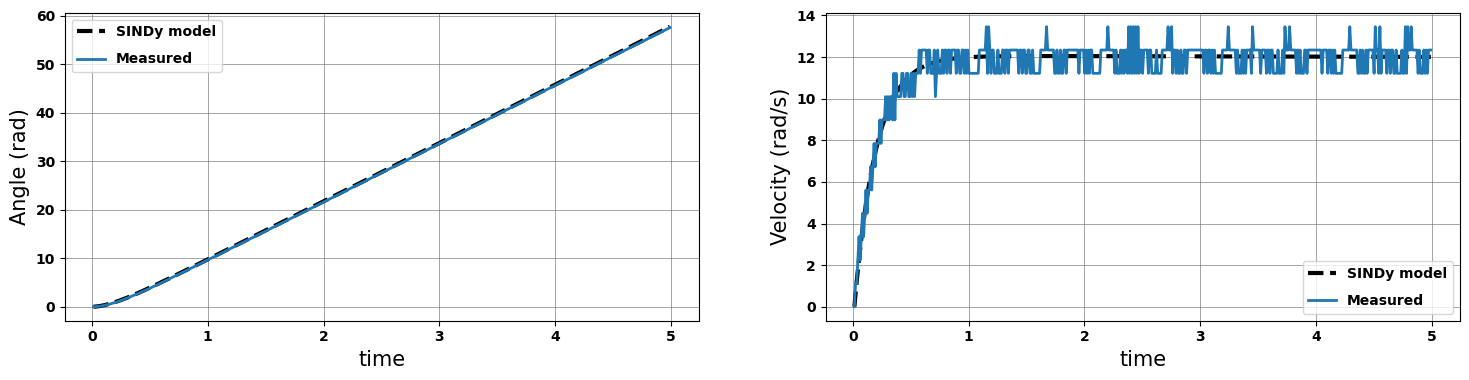

In [8]:
#fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
fig, axs = plt.subplots(1, 2,figsize = (18,4))
axs[0].plot(t, sim[:, 0], "k--", label="SINDy model", linewidth=3)
data.angle.plot(ax=axs[0],label="Measured")
axs[1].plot(t, sim[:, 1], "k--", label="SINDy model", linewidth=3)
data.velocity.plot(ax=axs[1], label = "Measured")

    
axs[0].grid()
axs[0].set_xlabel('time')
axs[0].set_ylabel('Angle (rad)')
axs[1].grid()
axs[1].set_xlabel('time')
axs[1].set_ylabel('Velocity (rad/s)')
#ax1.set_ylim(0,900)
axs[0].legend()
axs[1].legend()
#plt.savefig('Images/rlocus_load.pdf',dpi = 300, bbox_inches='tight')
plt.show()

In [9]:
Am = model.coefficients()[:, [1, 2]]
Bm = model.coefficients()[:,0].reshape((2,1))
#Bm = Bm/V 
V = 150
Bm = Bm/V#pwm 200 was given
Cm = np.array([1,0])
Dm = np.array([[0]])
motor_model_cont = control.StateSpace(Am,Bm,Cm,Dm)

### Closed loop position control

In [10]:
#lets define discrete time pic controller
kp = 7*180/np.pi;
ki = 2*180/np.pi;
z = cm.tf('z')
Gpid = kp + z*ki*Ts/(z-1) #+ kd*(z-1)/z
#for position control lets change the C 
Cm = np.array([1,0])
motor_model = control.StateSpace(Am,Bm,Cm,Dm)
motor_model_dis =cm.c2d(motor_model, 0.011, method='zoh')

act_motor_model = cm.feedback(cm.series(Gpid,motor_model_dis),1,-1) # converting rpm to degrees per second so 6
x,t= cm.step(act_motor_model)
x = 30*x*np.pi/180

(0.0, 2.0)

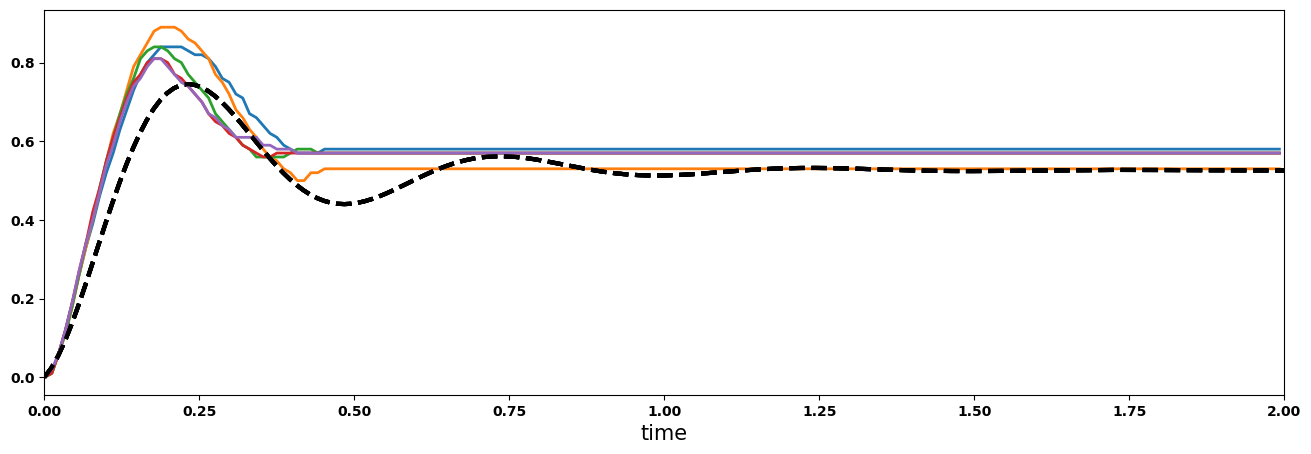

In [11]:
fig, ax1  = plt.subplots(figsize = (16,5))
for i in range(1,6):
    data = pd.read_csv("Real_Data/Pid_data/position_pid_control"+str(i)+".txt")
    data.time = ((data.time-28)/1000)
    data = data.set_index('time')
    data = data.query('time<2')
    data.angle.plot(ax=ax1)
    ax1.plot(t,x,"k--",linewidth = 3)
ax1.set_xlim(0,2)

(0.0, 2.0)

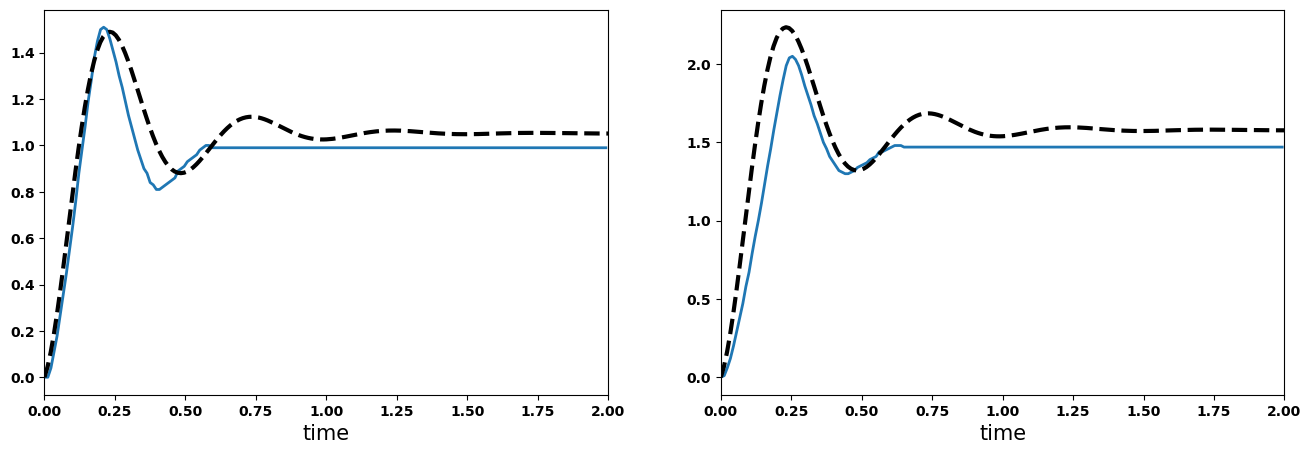

In [12]:
x,t= cm.step(act_motor_model)
x = 60*x*np.pi/180
fig, (ax1,ax2)  = plt.subplots(1,2,figsize = (16,5))
data = pd.read_csv("Real_Data/Pid_data/pid_control_60.txt")
data.time = ((data.time-28)/1000)
data = data.set_index('time')
data = data.query('time<2')
data.angle.plot(ax=ax1)
ax1.plot(t,x,"k--",linewidth = 3)
ax1.set_xlim(0,2)

x,t= cm.step(act_motor_model)
x = 90*x*np.pi/180
data = pd.read_csv("Real_Data/Pid_data/pid_control_90.txt")
data.time = ((data.time-28)/1000)
data = data.set_index('time')
data = data.query('time<2')
data.angle.plot(ax=ax2)
ax2.plot(t,x,"k--",linewidth = 3)
ax2.set_xlim(0,2)

### Analysis of ball and beam



In [13]:
data = pd.read_csv("Real_Data/angle_distance_velocity.txt")
data.time = (data.time/1000)-7
data = data.query('time<0.8')
data = data.query('time>0')
data = data.set_index("time")
Ts = data.index[4] - data.index[3]
m_ang = data.motor_angle

data = data[['ball_distance', 'ball_velocity']]

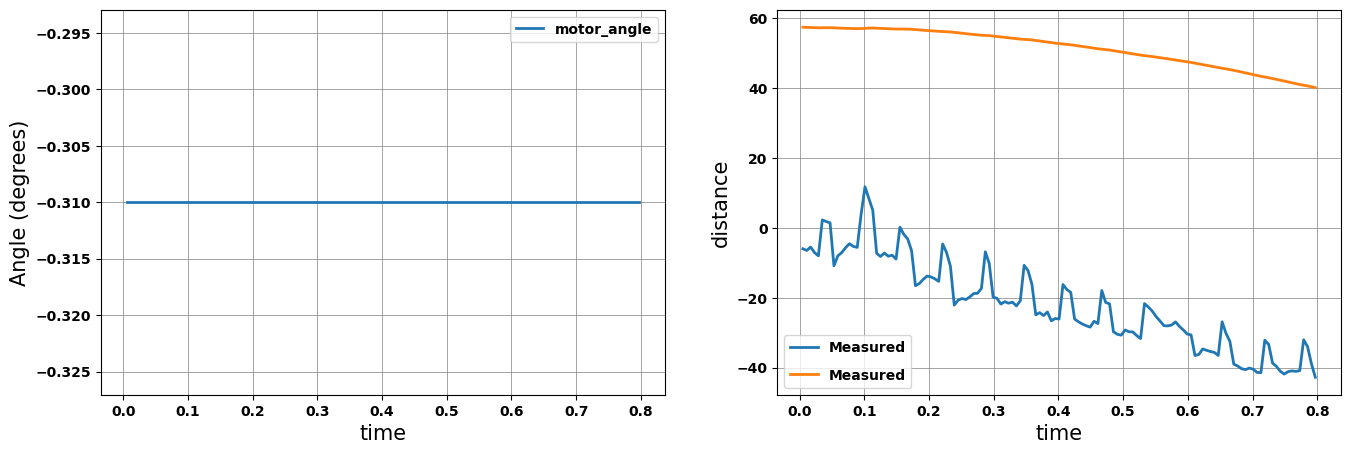

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
data.ball_velocity.plot(ax=ax2,label="Measured")
data.ball_distance.plot(ax=ax2, label = "Measured")
m_ang.plot(ax = ax1)
ax1.grid()
ax1.set_xlabel('time')
ax1.set_ylabel('Angle (degrees)')
ax2.grid()
ax2.set_xlabel('time')
ax2.set_ylabel('distance')
#ax1.set_xlim(0,0.65)
#ax2.set_xlim(0,0.65)
ax1.legend()
ax2.legend()
#plt.savefig('Images/rlocus_load.pdf',dpi = 300, bbox_inches='tight')
plt.show()

In [15]:
#lets identify the model
X = data.values
t = data.index.values

differentiation_method = ps.FiniteDifference(order=1)
feature_library = ps.PolynomialLibrary(degree=1)
optimizer = ps.STLSQ(threshold=0.01)

In [16]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "x_dot"],
)

model.fit(X, t=t)
model.print()

(x)' = -33.081 1 + 0.534 x + 0.754 x_dot
(x_dot)' = -5704.081 1 + 92.412 x + -41.248 x_dot


In [17]:
#lets extract the coefficents
Ab = model.coefficients()[:, [1, 2]]
Bb = model.coefficients()[:,0].reshape((2,1))
Bb = Bb/(-0.3)
# input is given 0.3 radians angle so
Cb = np.array([1,0])
Db = np.array([[0]])
ball_beam_model_cont = control.StateSpace(Ab,Bb,Cb,Db)


In [18]:
x0 = data.iloc[0].values
sim = model.simulate(x0, t=t)

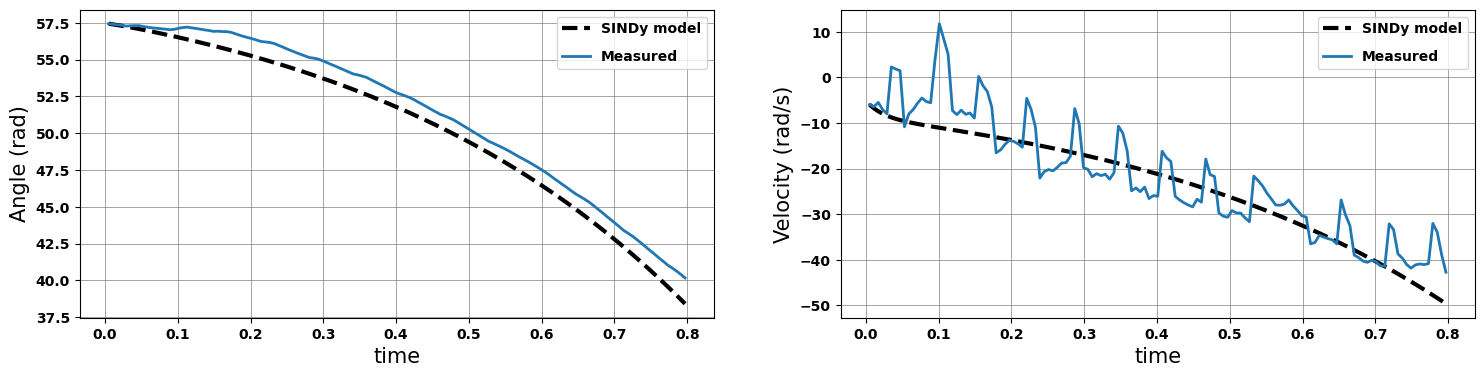

In [19]:
#fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
fig, axs = plt.subplots(1, 2,figsize = (18,4))
axs[0].plot(t, sim[:, 0], "k--", label="SINDy model", linewidth=3)
data.ball_distance.plot(ax=axs[0],label="Measured")
axs[1].plot(t, sim[:, 1], "k--", label="SINDy model", linewidth=3)
data.ball_velocity.plot(ax=axs[1], label = "Measured")

    
axs[0].grid()
axs[0].set_xlabel('time')
axs[0].set_ylabel('Angle (rad)')
axs[1].grid()
axs[1].set_xlabel('time')
axs[1].set_ylabel('Velocity (rad/s)')

#ax1.set_ylim(0,900)
axs[0].legend()
axs[1].legend()

#plt.savefig('Images/rlocus_load.pdf',dpi = 300, bbox_inches='tight')
plt.show()

#### Lets combine the models

In [20]:
Ts=0.01 #from measuring deltaT
system_model_open = control.series(motor_model_cont,ball_beam_model_cont)
#lets descretize
system_model_open =cm.c2d(system_model_open, Ts, method='zoh')
np.set_printoptions(suppress=True)


In [21]:
system_model_open.B.T

matrix([[0.00009604, 0.00412789, 0.00006852, 0.00753537]])

In [22]:
## lets design  a state estimator
### dsign a klaman filter 

A = system_model_open.A
B = system_model_open.B
G = 0.1*np.identity(A.shape[0])
C = np.identity(A.shape[0])
QN = 0.1*np.identity(A.shape[0])
RN = 0*np.identity(A.shape[0])

L, P, E = control.dlqe(A, G, C, QN, RN)  
L


matrix([[  1.00003346,   0.00869153,  -0.        ,  -0.        ],
        [ -0.00005471,   0.94869392,   0.        ,  -0.        ],
        [  1.73608465,   0.00675228,   1.00841692,   0.00620441],
        [156.43180508,   0.7311803 ,   0.76028616,   0.664674  ]])

In [23]:

#for linear quardratic regulator
RN = R = np.array([0.01])

K,P,E = control.dlqr(A,B, QN,RN)
K

matrix([[1249.70238328,   47.17752285,    8.75948433,    0.43911116]])

In [24]:
K = np.array([5249.70238328,   27.17752285,    60.75948433,    4.53911116]);
K # used in hardware

array([5249.70238328,   27.17752285,   60.75948433,    4.53911116])

In [25]:
data = pd.read_csv('Real_Data/final_data.txt')
data.time = (data.time/1000)-160
data = data.set_index('time')

In [26]:
data1 = data.query('time>8.6')
data1 = data1.query('time<20')
data1.index = data1.index-8.6
data3 = data.query('time>52.5')
data3 = data3.query('time<65')
data3.index = data3.index-52.5

<Axes: xlabel='time'>

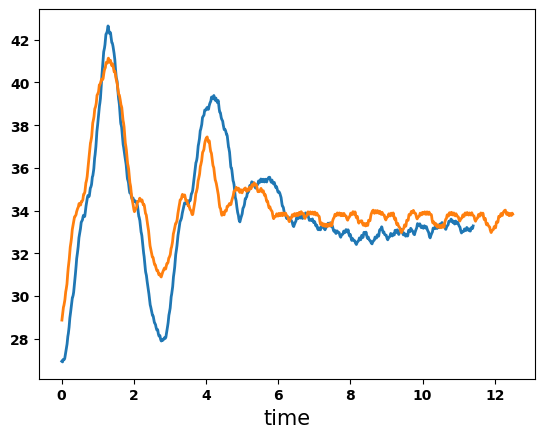

In [27]:
data1.ball_position.plot()

data3.ball_position.plot()